**1. Unzip the folder 'Project1'**

**2. Create 16 Statistical Feature Dataset**

In [ ]:
import pandas as pd
import numpy as np
from scipy.linalg import eigh
import glob
import os

def process_file(file_path):
    # Extract class information from the filename
    file_name = os.path.basename(file_path)
    class_info = file_name.split('_')[3]

    df = pd.read_csv(file_path)

    # 1. Count the occurrences of each StopID for each Frame Num
    frame_stop_counts = df.groupby(['Frame Num', 'StopID']).size().unstack(fill_value=0)
    frame_stop_counts.columns = [f"{col}_stop_counts" for col in frame_stop_counts.columns]

    # 2. Calculate the mean distance for each StopID for each Frame Num
    stop_distance_means = df.groupby(['Frame Num', 'StopID'])['Distance'].mean().unstack(fill_value=0)
    stop_distance_means.columns = [f"{col}_stop_distance_means" for col in stop_distance_means.columns]

    # 3. Calculate the mean and variance of StopID for each Frame Num
    stop_mean_variance = df.groupby('Frame Num')['StopID'].agg(['mean', 'var'])
    stop_mean_variance.columns = [f"StopID_{col}" for col in stop_mean_variance.columns]

    # 4. Calculate the mean distance for each Frame Num
    distance_means = df.groupby('Frame Num')['Distance'].mean().rename('Distance_mean')

    # 5. Calculate the mean Azimuth for each Frame Num
    azimuth_means = df.groupby('Frame Num')['Azimuth'].mean().rename('Azimuth_mean')

    # 6. Calculate the mean VerticalAngle for each Frame Num
    vertical_angle_means = df.groupby('Frame Num')['VerticalAngle'].mean().rename('VerticalAngle_mean')

    # 7. Calculate the mean and variance of Intensity for each Frame Num
    intensity_mean_variance = df.groupby('Frame Num')['Intensity'].agg(['mean', 'var'])
    intensity_mean_variance.columns = [f"Intensity_{col}" for col in intensity_mean_variance.columns]

    # 8. Calculate the eigenvalues of the covariance matrix for x, y, z for each Frame Num
    eig_values = df.groupby('Frame Num')[['X', 'Y', 'Z']].apply(lambda x: pd.Series(eigh(np.cov(x, rowvar=False))[0], index=['eig_cov_x', 'eig_cov_y', 'eig_cov_z']))

    # Create a DataFrame with the results
    result_df = pd.concat([frame_stop_counts, stop_distance_means, stop_mean_variance, distance_means, azimuth_means, vertical_angle_means, intensity_mean_variance, eig_values], axis=1)

    # Fill NaN values with 0
    result_df.fillna(0, inplace=True)

    # Add class column
    result_df['Class'] = class_info

    return result_df

# Path to the input files
input_path = 'path/to/your/input/*.csv'  # e.g., 'C:/user/documents/input/*.csv'
output_path = 'path/to/your/output/combined_output.csv'  # e.g., 'C:/user/documents/output/combined_output.csv'

# Process each file and combine the results
all_results = []
for file in glob.glob(input_path):
    result = process_file(file)
    all_results.append(result)

# Combine all results into a single DataFrame
combined_df = pd.concat(all_results)

# Save the result to a CSV file
combined_df.to_csv(output_path, index=True)

**3. K-Nearest Neighbor Model (K=10)**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# File Load
file_path = 'path/to/your/output/combined_output.csv'
data = pd.read_csv(file_path)

# Define Feature X and Target Y
X = data.drop(['Frame Num', 'Class'], axis=1)
y = data['Class']

# Divide Train set (70%) and Test set(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

# KNN Model (k=10)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = knn.score(X_train_scaled,y_train)
print(f'Train accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train accuracy: 0.9950525664811379
Test Accuracy: 0.9919215233698788


**4. Random Forest Model**

Train accuracy: 1.0
Test accuracy: 0.9945181765724178


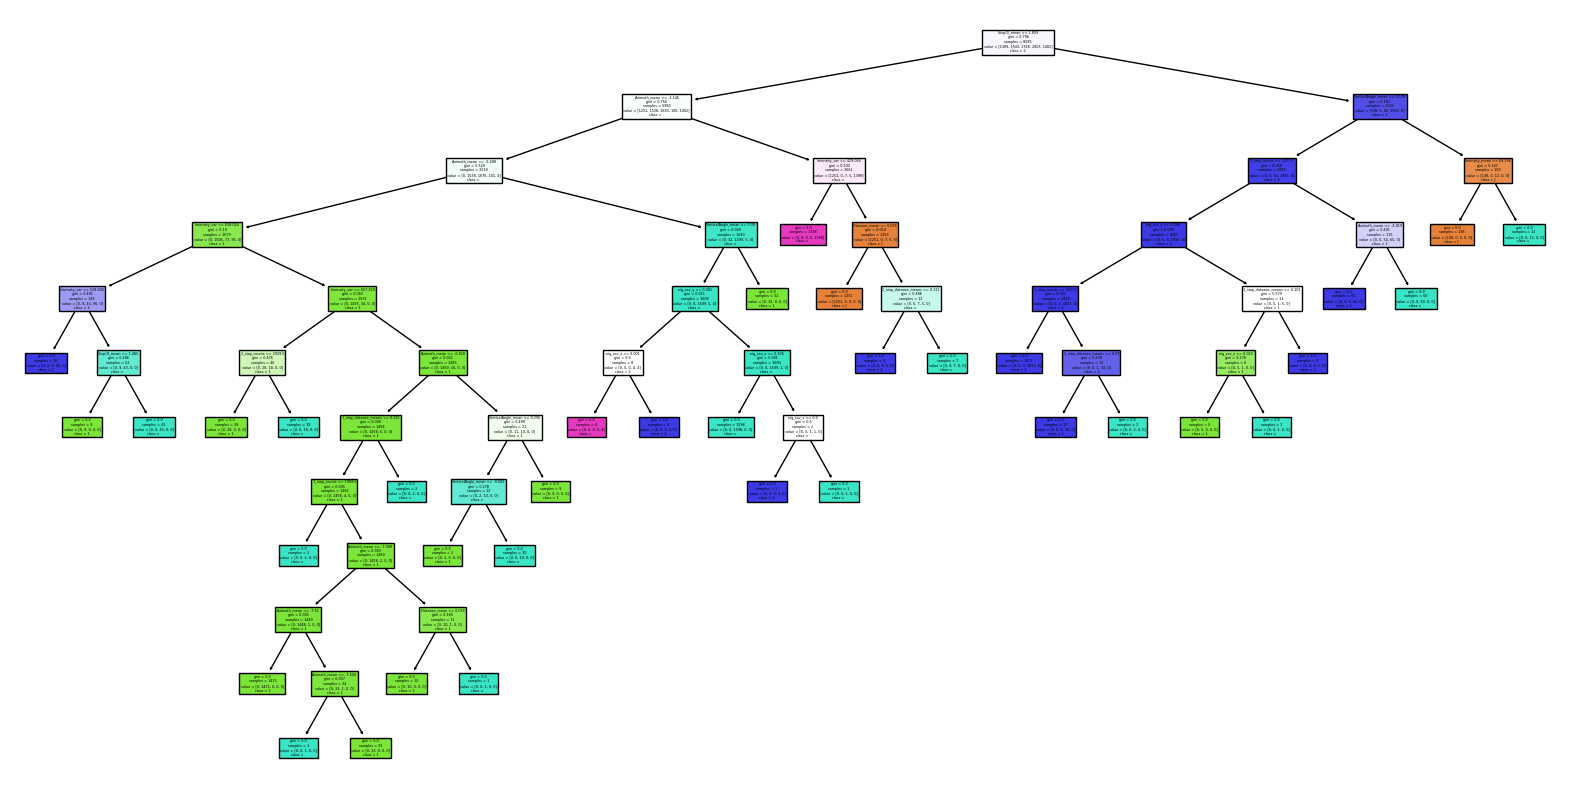

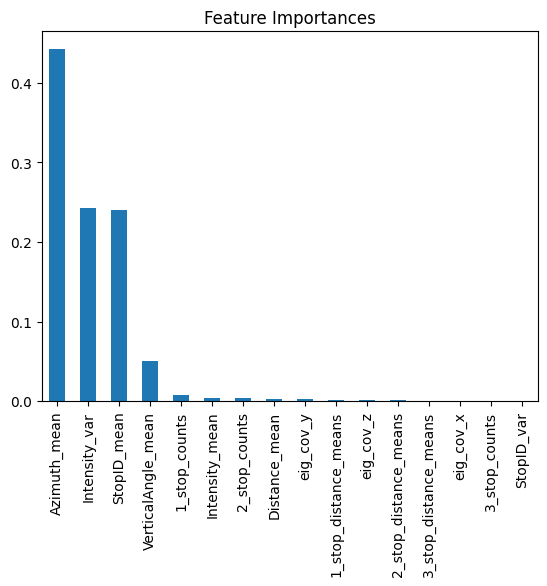

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# File Load
file_path = 'path/to/your/output/combined_output.csv'
data = pd.read_csv(file_path)

# Define features (X) and target (y)
X = data.drop(['Frame Num', 'Class'], axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the decision tree model
dt_classifier = DecisionTreeClassifier(max_depth=16, random_state=42)
dt_classifier.fit(X_train, y_train)

# Evaluate the model's accuracy on the test set
y_pred = dt_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = dt_classifier.score(X_train,y_train)
print(f'Train accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')

# Plot the tree structure
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt_classifier, filled=True, feature_names=X.columns, class_names=str(dt_classifier.classes_))
plt.show()

# Feature Importance
pd.Series(dt_classifier.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances')
plt.show()

**5. Deep Neural Network Model**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 10757 (42.02 KB)
Trainable params: 10757 (42.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
566/566 [==============================] - 5s 4ms/step - loss: 1.0622 - accuracy: 0.9309 - val_loss: 0.3988 - val_accuracy: 0.9699
Epoch 2/50

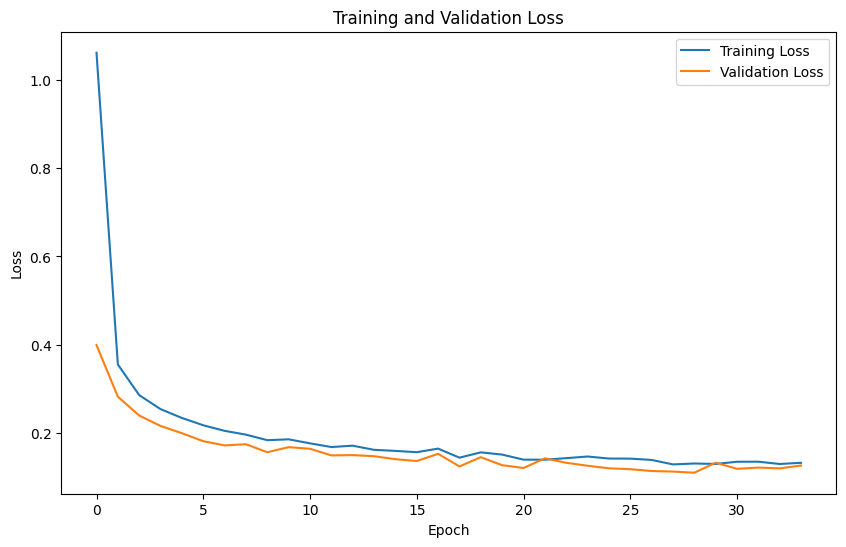

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2176      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 10757 (42.02 KB)
Trainable params: 10757 (42.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.regularizers import l2

# File Load
file_path = '/content/drive/MyDrive/combined output.csv'
data = pd.read_csv(file_path)

# Define features (X) and target (y)
X = data.drop(['Frame Num', 'Class'], axis=1)
y = data['Class']  # Use 'Class' column as target

# Data scaling
scaler = StandardScaler()

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encode the target variable
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train - 1, num_classes)
y_test_encoded = to_categorical(y_test - 1, num_classes)

# Early stopping callback setup
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build a DNN model with L2 regularization
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.02), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    Dense(num_classes, activation='softmax')
])

# Setup Adam optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(
    X_train_scaled, y_train_encoded,
    epochs=50,
    batch_size=10,
    verbose=1,
    validation_split=0.3,
    callbacks=[early_stopping]
)

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train_encoded, verbose=0)
print(f'Training Accuracy: {train_accuracy}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f'Test Accuracy: {test_accuracy}')

# Visualization of training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.summary()

**6. Accuracy Comparison**

KNN Mean Cross-Validation Accuracy: 0.9939391621486005
KNN Standard Deviation of Cross-Validation Accuracy: 0.002310740663505506
Random Forest Mean Cross-Validation Accuracy: 0.9996290188351343
Random Forest Standard Deviation of Cross-Validation Accuracy: 0.0005666832274632455
DNN Mean Cross-Validation Accuracy: 0.9954232394695282
DNN Standard Deviation of Cross-Validation Accuracy: 0.002415997149850832


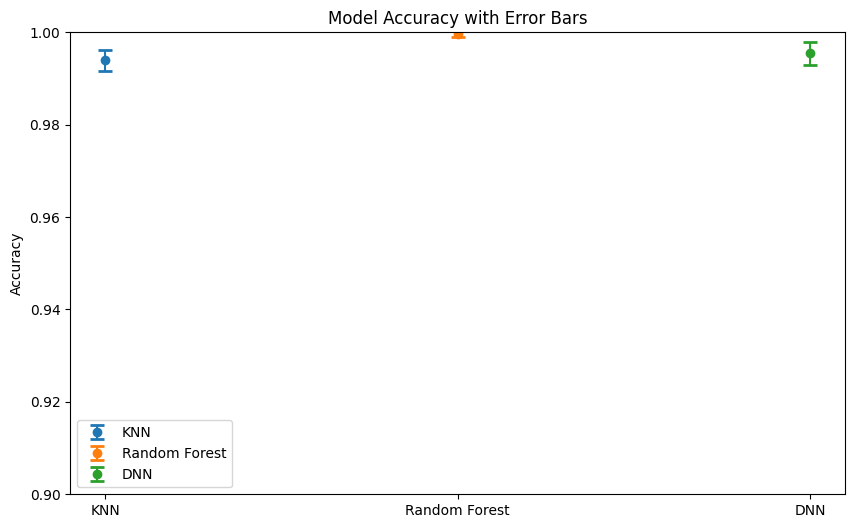

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2

# File Load
file_path = '/content/drive/MyDrive/combined output.csv'
data = pd.read_csv(file_path)

# Define features (X) and target (y)
X = data.drop(['Frame Num', 'Class'], axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Data scaling for KNN and Deep Learning
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Model (k=10)
k = 10
knn = KNeighborsClassifier(n_neighbors=k)

# Random Forest Model
rf_classifier = RandomForestClassifier(max_depth=16, random_state=42)

# Build DNN model function
def create_dnn_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.02), input_shape=(input_shape,)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Encode labels for DNN
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train - 1, num_classes)
y_test_encoded = to_categorical(y_test - 1, num_classes)

# Evaluate KNN Model with Cross-Validation
k_fold = 10
knn_cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=k_fold)

# Evaluate Random Forest Model with Cross-Validation
rf_cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=k_fold)

# Evaluate DNN Model with Cross-Validation
kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
dnn_cv_scores = []

for train_index, val_index in kf.split(X_train_scaled):
    X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_cv, y_val_cv = y_train_encoded[train_index], y_train_encoded[val_index]
    model = create_dnn_model(X_train_scaled.shape[1], num_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=10, verbose=0, validation_data=(X_val_cv, y_val_cv), callbacks=[early_stopping])
    score = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    dnn_cv_scores.append(score[1])

dnn_cv_scores = np.array(dnn_cv_scores)

# Calculate mean and standard deviation for KNN
knn_mean_cv_accuracy = np.mean(knn_cv_scores)
knn_std_cv_accuracy = np.std(knn_cv_scores)

# Calculate mean and standard deviation for Random Forest
rf_mean_cv_accuracy = np.mean(rf_cv_scores)
rf_std_cv_accuracy = np.std(rf_cv_scores)

# Calculate mean and standard deviation for DNN
dnn_mean_cv_accuracy = np.mean(dnn_cv_scores)
dnn_std_cv_accuracy = np.std(dnn_cv_scores)

print(f'KNN Mean Cross-Validation Accuracy: {knn_mean_cv_accuracy}')
print(f'KNN Standard Deviation of Cross-Validation Accuracy: {knn_std_cv_accuracy}')
print(f'Random Forest Mean Cross-Validation Accuracy: {rf_mean_cv_accuracy}')
print(f'Random Forest Standard Deviation of Cross-Validation Accuracy: {rf_std_cv_accuracy}')
print(f'DNN Mean Cross-Validation Accuracy: {dnn_mean_cv_accuracy}')
print(f'DNN Standard Deviation of Cross-Validation Accuracy: {dnn_std_cv_accuracy}')

# Visualization of accuracy with error bars for all models
plt.figure(figsize=(10, 6))
plt.errorbar(x=['KNN'], y=[knn_mean_cv_accuracy], yerr=[knn_std_cv_accuracy], fmt='o', capsize=5, capthick=2, label='KNN')
plt.errorbar(x=['Random Forest'], y=[rf_mean_cv_accuracy], yerr=[rf_std_cv_accuracy], fmt='o', capsize=5, capthick=2, label='Random Forest')
plt.errorbar(x=['DNN'], y=[dnn_mean_cv_accuracy], yerr=[dnn_std_cv_accuracy], fmt='o', capsize=5, capthick=2, label='DNN')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Error Bars')
plt.legend()
plt.ylim(0.99, 1.0)  # Adjust y-axis range as needed
plt.show()